## Introduction

This notebook follows this blog post https://domino.ai/blog/fitting-gaussian-process-models-python. The variable names etc. are set according to the online lecture of Conrell University https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote15.html and https://distill.pub/2019/visual-exploration-gaussian-processes/ 


In [49]:
import numpy as np
import matplotlib.pylab as plt
import scipy, os
from scipy.stats import norm


from palettable.cmocean.sequential import Ice_20# Oslo_20
palettable_cmap = Ice_20 #Ice_20
pal_cmap = palettable_cmap.mpl_colormap
# import warnings 
# warnings.filterwarnings("ignore")

### Multivariate Gaussian 
A multivariate gaussian distribution/ normal distribution is defined as
$$ \mathcal{N}(x,\mu,\Sigma) = \frac{1}{\left[(2 * \pi)^d * det(\Sigma)\right]^{1/2}} * \exp{\left(-\frac{1}{2} (x-\mu)^T \Sigma^{-1} (x-\mu) \right)}$$
where $\mu$ is the vecotor of mean values, $\Sigma$ is the covariance matrix containing the standard deviations on the diagonal and the "correlations" on the offdiagonals, $d$ is the dimension of $\mu$  


In [50]:
def multivariate_gauss(x,mu,Sigma):
	'''
	x - 1d array of arrays- lists of dimensions
	mu - 1d array, for each dimension only 1 mean value
	sigma - matrix n by n w/ n = lenght of mu
	'''
	
	#dimensions d
	d = len(mu)
	prefactor = ((2*np.pi)**d * np.linalg.det(Sigma))**1/2

	Sigma_inv = np.linalg.inv(Sigma)
	
	exp_argument = - 1/2 * ( ( ( (x-mu).T ).dot(Sigma_inv) ).dot(x-mu) )

	print(( (x-mu).T ).dot(Sigma_inv))
	print(np.exp(exp_argument))
	print()

	mGauss = 1/prefactor * np.exp(exp_argument)



	return mGauss

### Compare multivaraite gauss distro of SciPy and own build one in 1d

In [51]:
x = np.array([1,2])
mu = np.array([0,1])
s = np.array([
	[1,0],
	[0,1]
			  ])

print(multivariate_gauss(x,mu,s))
# print(gauss(x,mu,s))
from scipy.stats import multivariate_normal

print(multivariate_normal.pdf(x,mu,s))

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot_surface(x,np.linspace(-1,1,10),multivariate_gauss(x,mu,s))

[1. 1.]
0.36787944117144233

0.05854983152431917
0.05854983152431917


### Define RBF kernel
$$ k(x_1,x_2) = \theta_1^2 * \exp{\left( -\frac{(x_1 - x_2)^2}{2 \theta_2^2}  \right)} $$

### Define linear kernel
$$ k(x_1,x_2) = \theta_1^2  + \theta_2^2 (x_1 - \theta_3) ( x_2- \theta_3) \\
\qquad \qquad\qquad\quad=  \theta_1  + \theta_2 ( x_1x_2 - x_1 \theta_3 - x_2\theta_3 + \theta_3^2) \\
\qquad \qquad\qquad\quad= \theta_1  + \theta_2 ( x_1x_2 - \theta_3 (x_1 + x_2)+ \theta_3^2) 
$$

### Define periodic kernel
$$ k(x_1,x_2) = \theta_1^2 * \exp\left[ - 2 * { \sin^2 \left( \frac{\pi  |x_1-x_2|}{\theta_2}  \right)} / {\theta_3}^2 \right]

$$

In [52]:
def RBF_kernel_pairwise(x1,x2,parameters):
	theta1 = parameters[0]
	theta2 = parameters[1]
	# Pairwise kernel kreation
	return theta1 * np.exp( - (x1-x2)**2/(2*theta2**2)  )

def RBF_kernel(x1,x2,parameters):
	'''' 
		x1, x2 the 1D arrays of which the covarianc matrix is created
		parameters - 2 input parameters in an array for amplitute (here ~ 1 sigma range of prediction = theta 1, and theta 2 some scaling factor)
	'''
	theta1 = parameters[0] # ~ 1sigma
	theta2 = parameters[1] # ?
	# RBF kernel creation for all elements at once
	return theta1 * np.exp(-theta2/2 * np.subtract.outer(x1,x2)**2) #if x1 and x2 are 1D objects the kernel will be a 2d Matrix


def linear_kernel(x1,x2,parameters):
	'''' 
		x1, x2 the 1D arrays of which the covarianc matrix is created
		paramerts- 3 input parameters theta_2 ~ average distance from function mean, theta_1 = certainty around offset, theta_2 = offset
	'''

	theta_1 = parameters[0] # avg distance from theta3
	theta_2 = parameters[1] # ~ 1*sigma
	theta_3 = parameters[2] # offset

	return theta_1**2 + theta_2**2 *np.multiply.outer((x1 - theta_3),(x2-theta_3))

	# kernel_matrix = np.zeros((len(x1),len(x2) ))
	# for i in range(len(x1)):
	# 	for j in range(len(x2)):
	# 		kernel_matrix[i,j] = theta_1 + theta_2*(x1[i]*x2[j] - theta_3*(x1[i] + x2[j]) + theta_3*theta_3)

	# return kernel_matrix
	#return theta_1 + theta_2*(np.multiply.outer(x1,x2) - theta_3*np.add.outer(x1,x2) + theta_3**2)
	# return theta_1 + theta_2*(np.multiply.outer(x1-theta_3,x2-theta_3))


def periodic_kernel(x1,x2,parameters):
	'''' 
		x1, x2 the 1D arrays of which the covarianc matrix is created
		paramerts- 3 input parameters 
	'''

	pi = np.pi 

	theta_1 = parameters[0] # ~ 1*sigma
	theta_2 = parameters[1] # period 
	theta_3 = parameters[2] # lengthscale

	return theta_1**2 * np.exp( - 2 * np.sin( pi * np.abs(np.subtract.outer(x1,x2)) / theta_2  )**2 / theta_3**2 )





### Conditional probability (new Gaussian distribution)

The distribution of all possible functions is also a Gaussian distribution with covariance matrix 
$$ 
\Sigma = 
  \begin{bmatrix}
    K & K_* \\
    K_*^T & K_{**}
  \end{bmatrix} 
  = 
  \begin{bmatrix}
    k(x_0,x_0)      & k(x_0,x_1)        & \cdots  & k(x_0,x_{n})      & k(x_0,x_{test}) \\
    k(x_1,x_0)      & k(x_1,x_1)        &         &                   & k(x_1,x_{test}) \\
    \vdots          &                   & \ddots  &                   & \vdots \\
    k(x_n,x_0)      & k(x_n,x_1)        &         & \ddots            & k(x_{n},x_{test}) \\ 
    k(x_{test},x_0) & k(x_{test},x_1)   & \cdots  &  k(x_{test},x_{n}) & k(x_{test},x_{test}) \\


  \end{bmatrix} 
  
  $$

where 
- $K$ is the training kernel matrix (created from training data)
  - $K = kernel(x_{train},x_{train})$
- $K_*$ is the training-testing matrix
  - $K_* = kernel(x_{train},x_{test})$
- $K_*^T$ is the testing- training matrix
- $K_{**}$ is the testing kernel Matrix (created with test data)
  - $K_{**} = kernel(x_{test},x_{test})$

therefore the gaussian distribution becomes
$$ \mathcal{N}(\mu,\Sigma) = N(K_*^TK_{**}^{-1}y, \quad K - K_*^T K_{**}^{-1} K_*)$$


# Need for the conditional gauss?

In [53]:
def conditional_Gauss(x_test, x_train, y_test, kernel, parameters):
    
    K = kernel(x_train, x_train, parameters) # training kernel matrix
    K_x = kernel(x_train, x_test, parameters) # training-testing matrix
    K_xx = kernel(x_test, x_test, parameters) # testing Matrix

    # Calculate the new mean of the conditional probability
    mu = (K_x.T).dot(np.linalg.inv(K)).dot(y_test) 

    # Calculate the new covaraince matrix of the conditional probability
    sigma = K_xx - ( (K_x.T).dot(np.linalg.inv(K) ).dot(K_x))

    
    return(mu.squeeze(), sigma.squeeze()) #squeezing done in the blog post, not completly shure why needed

#### First use a zero mean function to test and plot $1\sigma$ of the RBF kernel with some arbitrary initial parameters for x1 and x2 = 0 

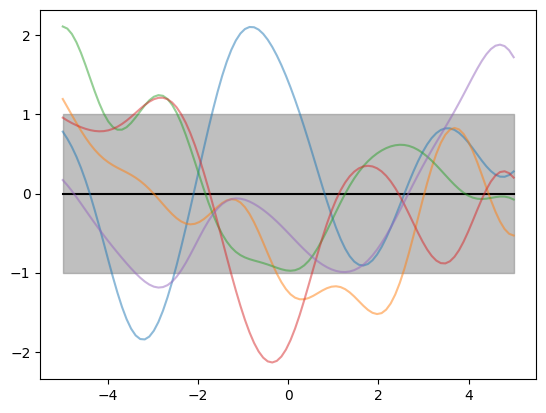

In [68]:
x_axis = np.linspace(-5,5,100)

# use some arbitrary parameters for RBF kernel
init_params = [1,1] # taken from blog post


mean_1 = np.zeros(len(x_axis)) # just 0 mean
cov_1 = RBF_kernel(x_axis,x_axis,init_params)


# plt.errorbar(x_axis, mean_1, yerr = np.diagonal(cov_1), capsize=5, ls = 'none', marker = '.')
plt.plot(x_axis, mean_1,color ='black')
plt.fill_between(x_axis,mean_1 - np.diagonal(cov_1) , mean_1 + np.diagonal(cov_1),color = 'gray',alpha=0.5,label  = r'1 $\sigma$')



prior_samples = np.random.multivariate_normal(mean_1, cov_1, size=5) 
plt.plot(x_axis, prior_samples.T, alpha=0.5)
plt.show()

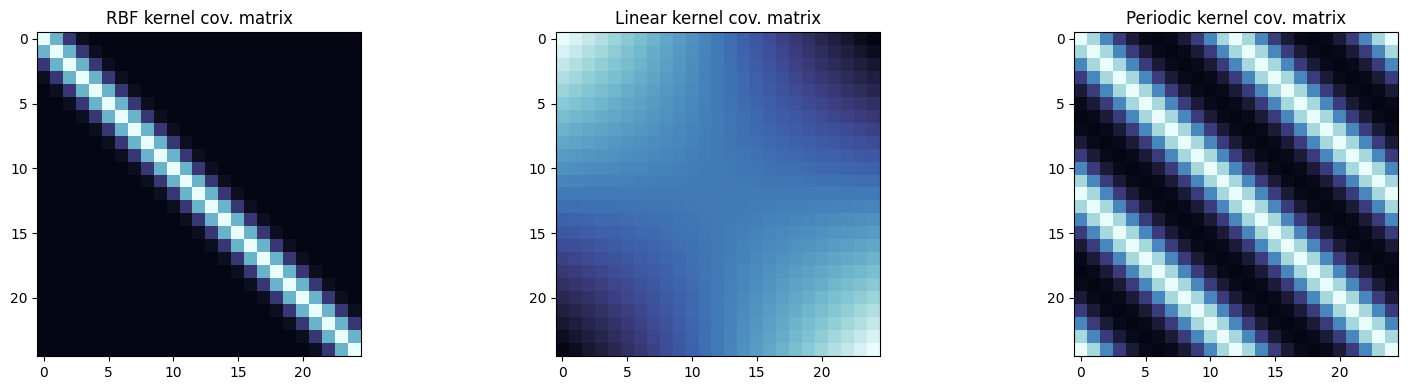

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(16,4))


x_axis = np.linspace(-10,10,25)


# ---------------------------------------- RBF Kernel ---------------------------------------- #

# use parameters defined before
cov_2 = RBF_kernel(x_axis,x_axis,init_params)

axs[0].imshow((cov_2), cmap=pal_cmap)
axs[0].set_title('RBF kernel cov. matrix')


# ---------------------------------------- Linear Kernel ---------------------------------------- #

init_params_lin = [1,1,0]#  avg distance from theta3 | ~ 1sigma | offset
cov_3 = linear_kernel(x_axis,x_axis,init_params_lin)


axs[1].imshow(linear_kernel(x_axis,x_axis,init_params_lin), cmap=pal_cmap)
axs[1].set_title('Linear kernel cov. matrix')


# -------------------------------------- Periodic Kernel ---------------------------------------- #

init_params_per = [1,1e1,1] #  ~ 1sigma | period | lenghtscale
cov_3 = linear_kernel(x_axis,x_axis,init_params_per)

axs[2].imshow(periodic_kernel(x_axis,x_axis,init_params_per), cmap=pal_cmap)
axs[2].set_title('Periodic kernel cov. matrix')


plt.tight_layout()
plt.show()

#### now start sampling test points (pairs of  x,y), since this is a test to show how gaussian processes work, both values are just arbitrary, in the original blog post the values are taken from a gaussian distribution - here fromblog post to check what is going on


In [56]:
def predict_value(x_test, y_test, x_train, kernel, kernel_parameters,noise):
	'''
	x_test - x value of test point, e.g. 
	y_test - y value of test point, e.g. measurement value
	x_train - Training data e.g. for Linear regressen the x axis 
	kernel - kernel function to use
	kernel_parameters hyperparameters of the kernel function
	noise - sigma**2 of the test points (e.g. measurement error)
	
	''' 

	identity = np.identity(len(x_test))

	K = kernel(x_train,x_train,kernel_parameters)
	K_x = kernel(x_train,x_test,kernel_parameters)
	K_xx = kernel(x_test, x_test, kernel_parameters) + identity.dot(noise) # testing Matrix


	# # Calculate the new mean of the conditional probability
	mu = (K_x).dot(np.linalg.inv(K_xx)).dot(y_test) 
	sigma = K - ( K_x.dot( np.linalg.inv(K_xx) ).dot(K_x.T)) 

	std = np.diag(sigma)

	return mu, sigma, std

# plt.imshow(sigma)

# print(mu-y_predicted_blog)

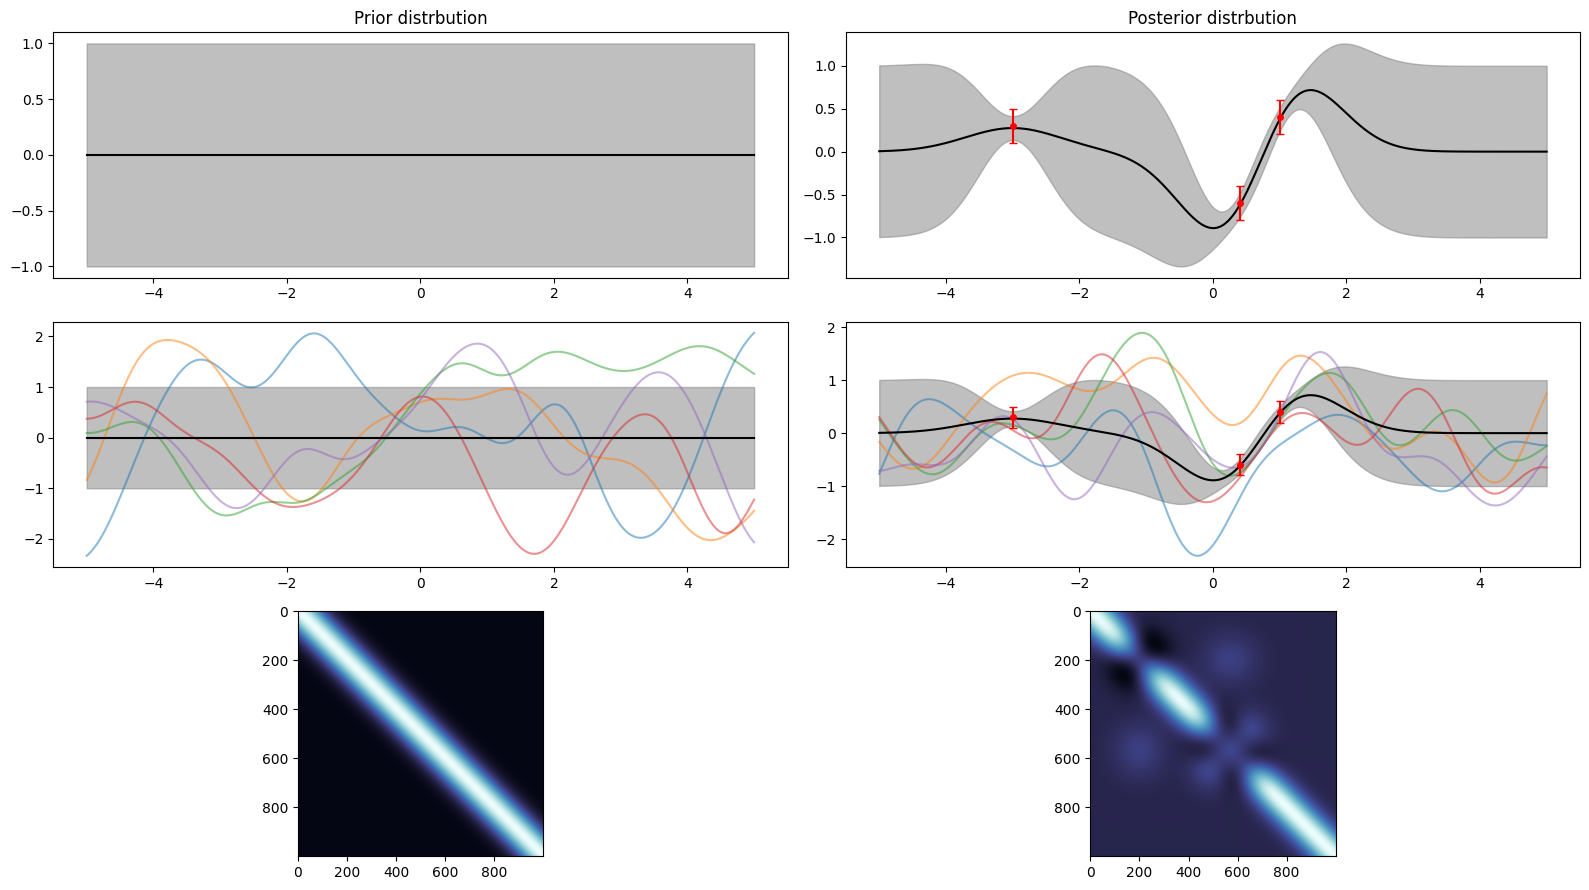

In [70]:
fig, axs = plt.subplots(3, 2, figsize=(16,9)) # 3 wide for last one


# Training Data - zero mean for all following processes
x_axis = np.linspace(-5, 5, 1000)


init_params_RBF = [1,2] # taken from blog post

# Test Data 
x_test = np.array([1,-3,0.4])
y_test = np.array([0.4,0.3,-0.6])
y_test_err = np.ones(len(y_test))*0.2


# Create zero mean values along x axis and create covaraince matrix for prior distribution

prior_mu = np.zeros(len(x_axis)) # zero mean for prior
prior_cov = RBF_kernel(x_axis, x_axis, init_params_RBF) # covariance matrix before introducing test points / measurements
pior_error = np.diagonal(prior_cov) # all the std values of the prior distribution

# Plot the prior interval without samples drawn
axs[0,0].plot(x_axis, prior_mu, color = 'black')
axs[0,0].fill_between(x_axis, prior_mu - pior_error, prior_mu + pior_error, color = 'gray', alpha=0.5, label = r'1 $\sigma$')

# Draw samples and plot them
prior_samples = np.random.multivariate_normal(prior_mu, prior_cov, size=5).T # draw samples form the GP
axs[1,0].plot(x_axis, prior_samples, alpha = 0.5 )
axs[1,0].plot(x_axis, prior_mu, color = 'black')
axs[1,0].fill_between(x_axis, prior_mu - pior_error, prior_mu + pior_error, color = 'gray', alpha=0.5, label = r'1 $\sigma$')


# plot the covaraince matrix
axs[2,0].imshow(RBF_kernel(x_axis, x_axis, init_params_RBF), cmap = pal_cmap)

axs[0,0].set_title('Prior distrbution')



# -------------------------------------------------- Introduce test data now -------------------------------------------------- #

# calculate predicted values with the conditional gaussian distribution
y_predictions, sigma_predictions, errors_predictions = predict_value(x_test, y_test, x_axis, RBF_kernel, init_params_RBF, y_test_err )

axs[0,1].plot(x_axis,y_predictions, color = 'black')
axs[0,1].errorbar(x_test, y_test, marker='.', yerr=y_test_err,ls='none', color = 'red', ms = 8, capsize=3)
axs[0,1].fill_between(x_axis, y_predictions - errors_predictions, y_predictions + errors_predictions, color = 'gray', alpha=0.5, label = r'1 $\sigma$')


# Get Posteriror samples 
posterior_samples = np.random.multivariate_normal(y_predictions, sigma_predictions, size=5).T # draw samples form the GP
axs[1,1].plot(x_axis, posterior_samples, alpha = 0.5 )

axs[1,1].plot(x_axis, y_predictions, color = 'black')
axs[1,1].errorbar(x_test, y_test,marker='.', yerr = y_test_err, ls='none', color = 'red', ms = 8, capsize=3)
axs[1,1].fill_between(x_axis, y_predictions - errors_predictions, y_predictions + errors_predictions, color = 'gray', alpha=0.5, label = r'1 $\sigma$')


#plot the covariance matrix 
axs[2,1].imshow(sigma_predictions, cmap=pal_cmap)
axs[0,1].set_title('Posterior distrbution')

plt.tight_layout()
plt.show()


In [58]:
x, y = np.meshgrid(x_axis, x_axis)


# print(np.shape(pos))

mean = prior_mu 
cov = prior_cov
# x, y = np.mgrid[-10:10:.1, -10:10:.1]
pos = np.dstack((x, y))
z_1 = np.ones((1000, 1000))

rv = multivariate_normal(mean, cov, allow_singular=True)

# print(rv.pdf(x


# for i in range(len(x_axis)):
# 	for j in range(len(x_axis)):

print(np.shape(prior_cov))

(1000, 1000)


C:\Users\Sebastian Nutz\AppData\Local\Temp\ipykernel_2192\1844930355.py:48: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  posterior_samples = np.random.multivariate_normal(y_predictions, sigma_predictions, size=5).T # draw samples form the GP


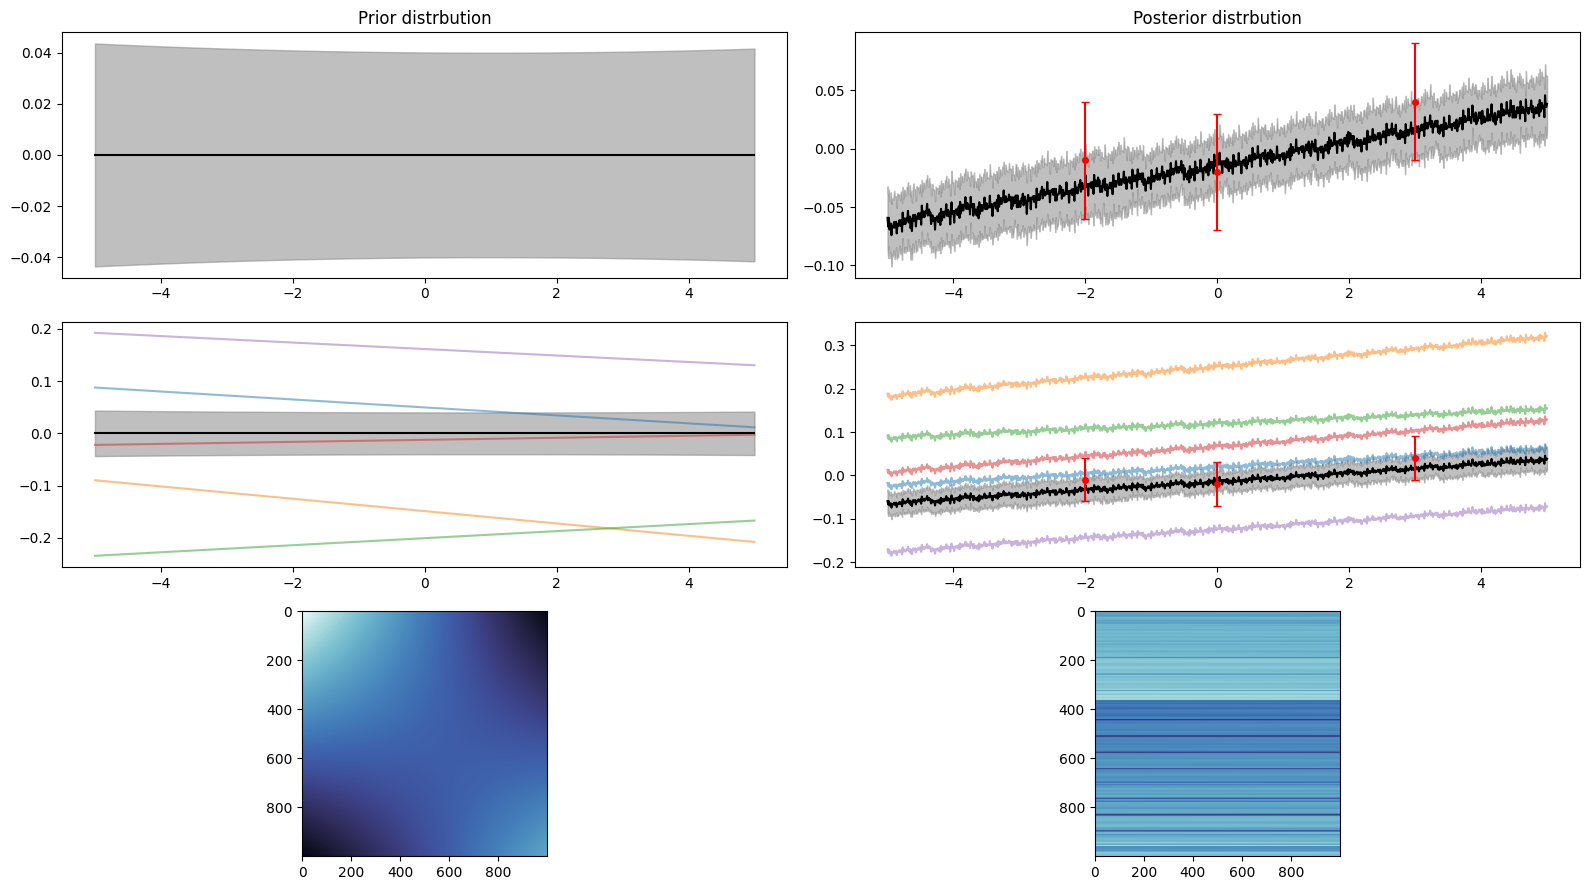

In [59]:
fig, axs = plt.subplots(3, 2, figsize=(16,9)) # 3 wide for last one


# define new initial parameters and test points
init_params_lin = [0.2, 1e-2, 1] # avg distance from theta3 | ~ 1sigma | offset

x_test = np.array([-2,0,3])
y_test = np.array([-0.01,-0.02,0.04])
y_test_err = np.ones(len(y_test))*0.05



# Create zero mean values along x axis and create covaraince matrix for prior distribution

prior_mu = np.zeros(len(x_axis)) # zero mean for prior
prior_cov = linear_kernel(x_axis, x_axis, init_params_lin) # covariance matrix before introducing test points / measurements
pior_error = np.diagonal(prior_cov) # all the std values of the prior distribution

# Plot the prior interval without samples drawn
axs[0,0].plot(x_axis,prior_mu, color = 'black')
axs[0,0].fill_between(x_axis, prior_mu - pior_error , prior_mu + pior_error, color = 'gray', alpha=0.5, label = r'1 $\sigma$')

# Draw samples and plot them
prior_samples = np.random.multivariate_normal(prior_mu, prior_cov, size=5).T # draw samples form the multivariate gaussian
axs[1,0].plot(x_axis, prior_samples, alpha = 0.5 )
axs[1,0].plot(x_axis, prior_mu, color = 'black')
axs[1,0].fill_between(x_axis, prior_mu - pior_error , prior_mu + pior_error, color = 'gray', alpha=0.5, label = r'1 $\sigma$')


# plot the covaraince matrix
axs[2,0].imshow(linear_kernel(x_axis, x_axis, init_params_lin), cmap = pal_cmap)

axs[0,0].set_title('Prior distrbution')



# -------------------------------------------------- Introduce test data now -------------------------------------------------- #

# calculate predicted values with the conditional gaussian distribution
y_predictions, sigma_predictions, errors_predictions = predict_value(x_test, y_test, x_axis, linear_kernel, init_params_lin, y_test_err )

axs[0,1].plot(x_axis, y_predictions, color = 'black')
axs[0,1].errorbar(x_test, y_test,marker ='.', yerr = y_test_err, ls = 'none', color = 'red', ms = 8, capsize = 3)
axs[0,1].fill_between(x_axis, y_predictions - errors_predictions, y_predictions + errors_predictions, color = 'gray', alpha = 0.5, label = r'1 $\sigma$')


# Get Posteriror samples 
posterior_samples = np.random.multivariate_normal(y_predictions, sigma_predictions, size=5).T # draw samples form the GP
axs[1,1].plot(x_axis,posterior_samples, alpha = 0.5 )

axs[1,1].plot(x_axis, y_predictions, color = 'black')
axs[1,1].errorbar(x_test, y_test,marker='.', yerr = y_test_err, ls = 'none', color = 'red', ms = 8, capsize=3)
axs[1,1].fill_between(x_axis, y_predictions - errors_predictions, y_predictions + errors_predictions, color = 'gray', alpha = 0.5, label = r'1 $\sigma$')


#plot the covariance matrix 
axs[2,1].imshow(sigma_predictions, cmap=pal_cmap)
axs[0,1].set_title('Posterior distrbution')



plt.tight_layout()
plt.show()




# # Own implementation
# y_predictions, sigma_predictions, errors_predictions = predict_value(x_test,y_test,x_axis,linear_kernel,init_params_lin, y_test_err )


# plt.plot(x_axis,y_predictions, color = 'black')
# plt.errorbar(x_test,y_test,marker='.', yerr=y_test_err,ls='none', color = 'red', ms = 8, capsize=3)
# plt.fill_between(x_axis,y_predictions- errors_predictions ,y_predictions + errors_predictions,color = 'gray',alpha=0.5,label  = r'1 $\sigma$')
# plt.show()


# #plot the covariance matrix 

# # print(sigma_predictions)
# plt.imshow(sigma_predictions, cmap=pal_cmap)
# plt.show()

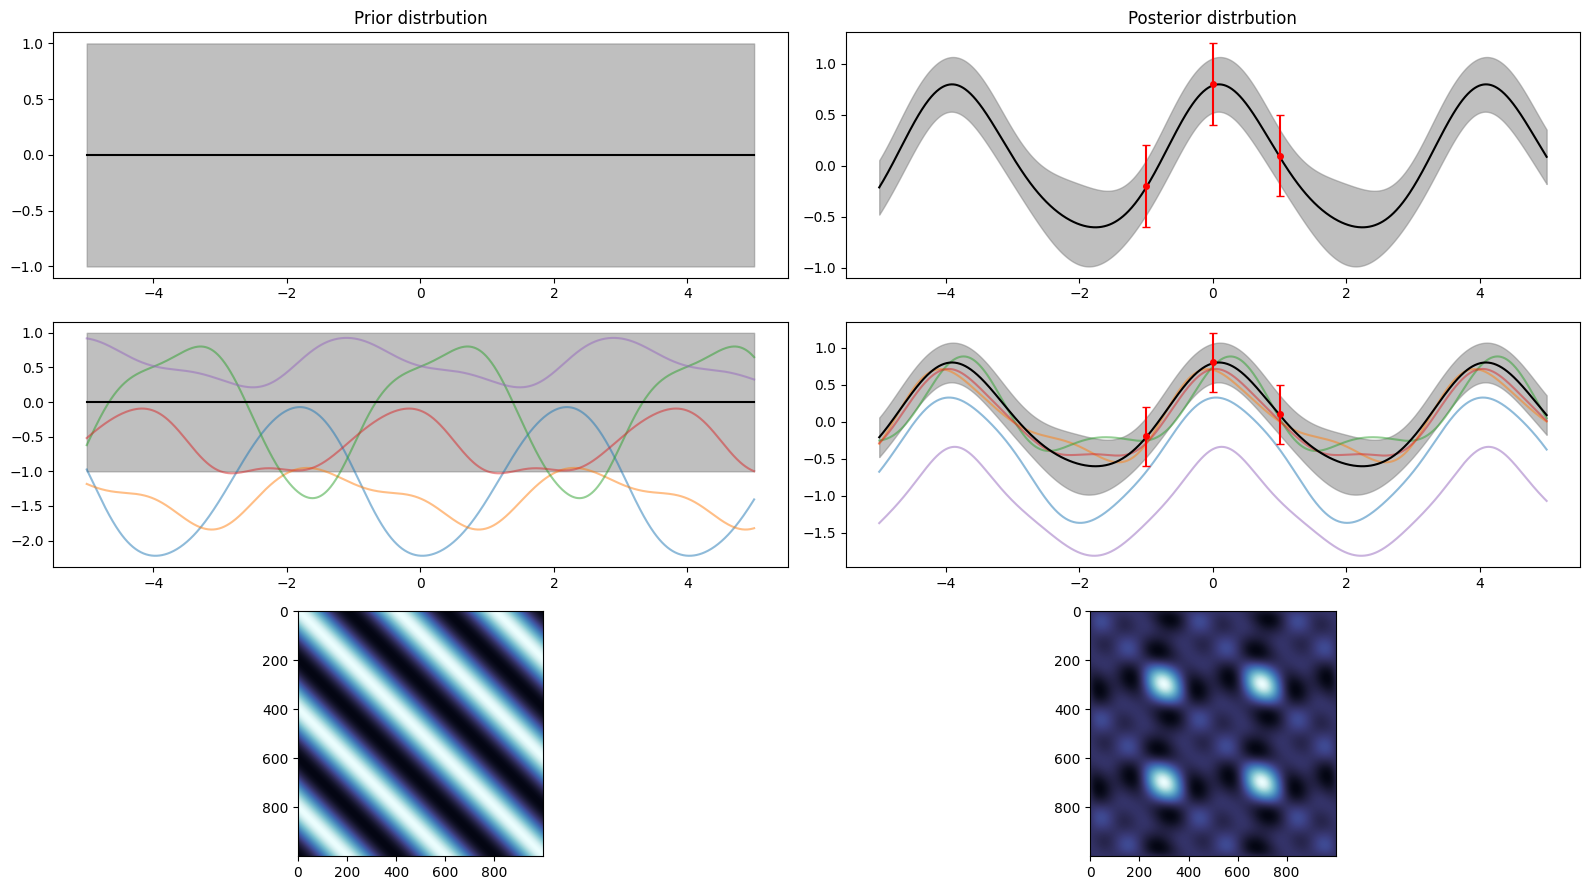

In [60]:
fig, axs = plt.subplots(3, 2, figsize=(16,9)) # 3 wide for last one


init_params_per = [1,4,2] #  ~ 1sigma | period | lenghtscale

x_test = np.array([-1,0,1])
y_test = np.array([-0.2,0.8,0.1])
y_test_err = np.ones(len(y_test))*0.4


# Create zero mean values along x axis and create covaraince matrix for prior distribution

prior_mu = np.zeros(len(x_axis)) # zero mean for prior
prior_cov = periodic_kernel(x_axis, x_axis, init_params_per) # covariance matrix before introducing test points / measurements
pior_error = np.diagonal(prior_cov) # all the std values of the prior distribution

# Plot the prior interval without samples drawn
axs[0,0].plot(x_axis, prior_mu, color = 'black')
axs[0,0].fill_between(x_axis, prior_mu - pior_error, prior_mu + pior_error, color = 'gray', alpha=0.5, label = r'1 $\sigma$')

# Draw samples and plot them
prior_samples = np.random.multivariate_normal(prior_mu, prior_cov, size=5).T # draw samples form the GP
axs[1,0].plot(x_axis, prior_samples, alpha = 0.5 )
axs[1,0].plot(x_axis, prior_mu, color = 'black')
axs[1,0].fill_between(x_axis, prior_mu - pior_error, prior_mu + pior_error, color = 'gray', alpha=0.5, label = r'1 $\sigma$')


# plot the covaraince matrix
axs[2,0].imshow(periodic_kernel(x_axis, x_axis, init_params_per), cmap = pal_cmap)

axs[0,0].set_title('Prior distrbution')



# -------------------------------------------------- Introduce test data now -------------------------------------------------- #

# calculate predicted values with the conditional gaussian distribution
y_predictions, sigma_predictions, errors_predictions = predict_value(x_test, y_test, x_axis, periodic_kernel, init_params_per, y_test_err )

axs[0,1].plot(x_axis,y_predictions, color = 'black')
axs[0,1].errorbar(x_test, y_test, marker='.', yerr=y_test_err,ls='none', color = 'red', ms = 8, capsize=3)
axs[0,1].fill_between(x_axis, y_predictions - errors_predictions, y_predictions + errors_predictions, color = 'gray', alpha=0.5, label = r'1 $\sigma$')


# Get Posteriror samples 
posterior_samples = np.random.multivariate_normal(y_predictions, sigma_predictions, size=5).T # draw samples form the GP
axs[1,1].plot(x_axis, posterior_samples, alpha = 0.5 )

axs[1,1].plot(x_axis, y_predictions, color = 'black')
axs[1,1].errorbar(x_test, y_test,marker='.', yerr = y_test_err, ls='none', color = 'red', ms = 8, capsize=3)
axs[1,1].fill_between(x_axis, y_predictions - errors_predictions, y_predictions + errors_predictions, color = 'gray', alpha=0.5, label = r'1 $\sigma$')


#plot the covariance matrix 
axs[2,1].imshow(sigma_predictions, cmap=pal_cmap)
axs[0,1].set_title('Posterior distrbution')

plt.tight_layout()
plt.show()



plt.show()

### Periodic cernel implementation #1

In [61]:



# # Own implementation
# y_predictions, sigma_predictions, errors_predictions = predict_value(x_test,y_test,x_axis,periodic_kernel, init_params_per, y_test_err)


# axs[0,0].plot(x_axis,y_predictions, color = 'black')
# axs[0,0].errorbar(x_test,y_test,marker='.', yerr=y_test_err,ls='none', color = 'red', ms = 8, capsize=3)
# axs[0,0].fill_between(x_axis,y_predictions- errors_predictions ,y_predictions + errors_predictions,color = 'gray',alpha=0.5,label  = r'1 $\sigma$')
# axs[1,0].imshow(sigma_predictions, cmap=pal_cmap)




# init_params_per = [2,6,1e2] 
# x_test = np.array([-1,0,1,4])
# y_test = np.array([0,1,0,-0.2])
# y_test_err = np.ones(len(y_test))*0.4
# # Own implementation
# axs[0,1].errorbar(x_test,y_test,marker='.', yerr=y_test_err,ls='none', color = 'red', ms = 8, capsize=3)
# y_predictions, sigma_predictions, errors_predictions = predict_value(x_test,y_test,x_axis,periodic_kernel, init_params_per, y_test_err)

# axs[0,1].plot(x_axis,y_predictions, color = 'black')
# axs[0,1].fill_between(x_axis,y_predictions- errors_predictions ,y_predictions + errors_predictions,color = 'gray',alpha=0.5,label  = r'1 $\sigma$')
# axs[1,1].imshow(sigma_predictions, cmap=pal_cmap)


# init_params_per = [1,5,2] 

# x_test = np.array([0,1,2.2,-1,4,-2])
# y_test = np.array([1,0,0.8,-0.2,0.2,0.2])
# y_test_err = np.ones(len(y_test))*0.1

# # Own implementation
# y_predictions, sigma_predictions, errors_predictions = predict_value(x_test,y_test,x_axis,periodic_kernel, init_params_per, y_test_err)

# axs[0,2].plot(x_axis,y_predictions, color = 'black')
# axs[0,2].plot(x_test,y_test,marker='.', ls='none', color = 'red', ms = 8)
# axs[0,2].fill_between(x_axis,y_predictions- errors_predictions ,y_predictions + errors_predictions,color = 'gray',alpha=0.5,label  = r'1 $\sigma$')
# axs[1,2].imshow(sigma_predictions, cmap=pal_cmap)



### Cornell University did fail with notation here???

In [62]:
# def predict_value(x_test, x_train, y_train , kernel, kernel_parameters, training_cov):

# 	K =  training_cov #kernel(x_train, x_train, kernel_parameters) # training kernel matrix
# 	# K_x = kernel(x_train, x_test, kernel_parameters) # training-testing matrix
# 	K_xx = kernel(x_test, x_test, kernel_parameters) # testing Matrix
	

# 	mu = np.zeros(len(x_train))
# 	sigma = np.zeros(((len(x_train)+len(y_train)),(len(x_train))+len(y_train)))
# 	sigma = np.zeros(len(x_train))
# 	# print(sigma)
# 	# print(np.shape(sigma))



# 	for i in range(len(x_train)):
		
# 	# K_x needs to be calculated pairwise because it is not a square matrix 
		
# 		# create array of zeros as long as the training data, for pairwise creation of K_*
# 		K_x = np.zeros(len(x_test)) 
		
# 		for j in range(len(x_test)):
# 			K_x[j] = kernel(x_train[i],x_test[j],init_params)

# 		# Calculate the new mean of the conditional probability
# 		mu[i] = (K_x.T).dot(np.linalg.inv(K)).dot(y_train) 

#     	# Calculate the new covaraince matrix of the conditional probability

# 		# print(np.shape(K_xx),np.shape(K_x),np.shape(K))

# 		sigma[i] = K_xx - ( (K_x.T).dot(np.linalg.inv(K) ).dot(K_x))

	
# 	return(mu, sigma) #squeezing done in the blog post, not completly shure why needed


# x = np.array([1])
# y = np.array([0.4])
# s_1 = RBF_kernel(x,x,init_params)

# y_predicted, sigma_predicted = predict_value(x,x_axis,y,RBF_kernel,init_params,s_1)


# # plt.errorbar(x_axis, y_prediced, yerr = sigma_predicted, capsize=5, ls = 'none', marker = '.')
# # plt.fill_between(x_axis,y_prediced- sigma_predicted ,y_prediced + sigma_predicted,color = 'gray',alpha=0.5,label  = r'1 $\sigma$')
# print(y_predicted-y_predicted_blog,sigma_predicted_blog-sigma_predicted)

# Needed to change K with K_xx in mu and sigma, then it should work


In [63]:

# x_train = x_axis
# kernel_parameters = [1,10]

# x_test = np.array([1])
# y_test = np.array([0.4])

# # x_test = np.append(x_train,x_test_given)
# # y_test = np.append(np.zeros(len(x_train)),y_test_given)

# # mu = np.zeros(len(x_train))
# # sigma = np.zeros(((len(x_train)+len(y_train)),(len(x_train))+len(y_train)))
# # sigma = np.zeros(len(x_train))
# # print(sigma)
# # print(np.shape(sigma))



# for i in range(len(x_train)):
	
# # K_x needs to be calculated pairwise because it is not a square matrix 
	
# 	# create array of zeros as long as the training data, for pairwise creation of K_*
# 	K_x = np.zeros(len(x_test)) 
	
# 	for j in range(len(x_test)):
# 		K_x[j] = RBF_kernel(x_train[i],x_test[j],init_params)

# K = RBF_kernel(x_train,x_train,kernel_parameters)
# K_x = RBF_kernel(x_train,x_test,init_params)
# K_xx = RBF_kernel(x_test, x_test, kernel_parameters) # testing Matrix



# # print(np.shape(y_test))
# # print(np.shape(K))
# # print(np.shape(K_x))
# # print(np.shape(K_xx))



# 	# # Calculate the new mean of the conditional probability
# mu = (K_x).dot(np.linalg.inv(K_xx)).dot(y_test) 
# sigma = K - ( (K_x).dot(np.linalg.inv(K_xx) ).dot(K_x.T))

# # print(mu)
# # print(sigma)


# plt.imshow(sigma)



# print(mu-y_predicted_blog)
# # print(y_prediced)

# 	# # Calculate the new covaraince matrix of the conditional probability

# 	# # print(np.shape(K_xx),np.shape(K_x),np.shape(K))


from blog post


In [64]:
def predict(x_train, data, kernel, params, sigma, t):
    k = np.array([kernel(x_train, y, params) for y in data]) #k_x
    Sinv = np.linalg.inv(sigma) # k_xx
    y_pred = (k.dot(Sinv)).dot(t) #k_x * k** * y
    sigma_new = kernel(x_train, x_train, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

# x = [1]
# y = [0.4]
# s_1 = RBF_kernel(x,x,init_params)


# # predict(x_axis[0], x, RBF_kernel, init_params, s_1, y)

# predictions = [predict(i, x, RBF_kernel, init_params, s_1, y) for i in x_axis]

# y_predicted_blog, sigma_predicted_blog = np.transpose(predictions)

# plt.errorbar(x_axis, y_predicted_blog, yerr = sigma_predicted_blog, capsize=5, ls = 'none', marker = '.')